## FROM JSON to GRAPH


keep this with K-nearest, can be useful for the qgis...

In [1]:
"""import json
import networkx as nx
import numpy as np
from shapely.geometry import Polygon, Point
from scipy.spatial import KDTree

# === Load the enriched JSON
json_path = r"C:\Users\Andrea\Desktop\thesis\rotated_json\dsm_045deg_with_mrt.json"

with open(json_path) as f:
    data = json.load(f)

G = nx.Graph()

# === 1. Add street node
street_poly = Polygon(data["street"])
street_centroid = street_poly.centroid
s_id = "s_0"
s_attr = data["street_attributes"]
G.add_node(s_id, 
           type="street", 
           x=street_centroid.x, 
           y=street_centroid.y, 
           **s_attr)

# === 2. Add building nodes
building_nodes = []
building_coords = []

for i, bldg in enumerate(data["buildings"]):
    b_id = f"b_{i}"
    poly = Polygon(bldg["footprint"])
    center = poly.centroid
    building_coords.append([center.x, center.y])
    G.add_node(b_id,
               type="building",
               x=center.x,
               y=center.y,
               height=bldg["height"])
    building_nodes.append(b_id)

# === 3. Add edges: building ↔ street
tree = KDTree(np.array(building_coords))
s_coord = np.array([street_centroid.x, street_centroid.y])
dists, idxs = tree.query(s_coord, k=len(building_nodes))

for i, b_id in enumerate(building_nodes):
    dist = np.linalg.norm(s_coord - np.array(building_coords[i]))
    G.add_edge(b_id, s_id, weight=dist)

# === 4. Optional: Add edges between buildings (within threshold)
threshold = 50  # meters
b_tree = KDTree(np.array(building_coords))
pairs = b_tree.query_pairs(r=threshold)

for i, j in pairs:
    b1 = building_nodes[i]
    b2 = building_nodes[j]
    dist = np.linalg.norm(np.array(building_coords[i]) - np.array(building_coords[j]))
    G.add_edge(b1, b2, weight=dist)

# === Done
print(f"✅ Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")"""


✅ Graph created with 3 nodes and 2 edges.



=== NODE FEATURES ===
 id     type             x             y   area  width  mrt_mean  dir_sin  dir_cos  height
s_0   street  4.850638e-16  1.940255e-15 5000.0   50.0 30.687675 0.707107 0.707107     NaN
b_0 building  2.474874e+01 -2.474874e+01    NaN    NaN       NaN      NaN      NaN    50.0
b_1 building -2.474874e+01  2.474874e+01    NaN    NaN       NaN      NaN      NaN    50.0

=== EDGE FEATURES ===
source target  weight
   s_0    b_0     0.0
   s_0    b_1     0.0
   b_0    b_1    50.0


C:\Users\Andrea\AppData\Local\Temp\ipykernel_16108\1096790969.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


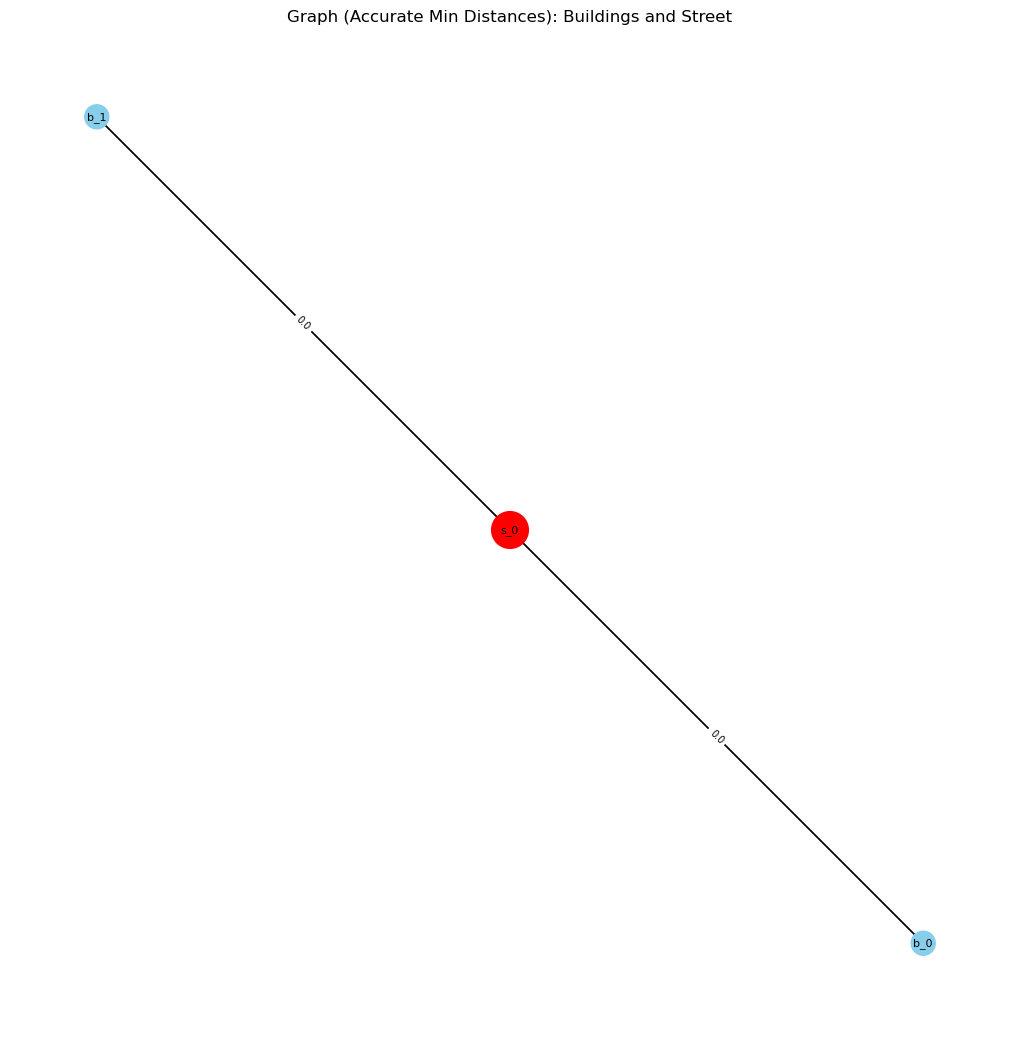

In [6]:
import json
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

# === FILE PATH TO YOUR JSON ===
json_path = r"C:\Users\Andrea\Desktop\thesis\rotated_json\dsm_045deg_with_mrt.json"

# === 1. Load JSON
with open(json_path, "r") as f:
    data = json.load(f)

# === 2. Build Graph
G = nx.Graph()

# Add street node
street_poly = Polygon(data["street"])
street_centroid = street_poly.centroid
s_id = "s_0"
s_attr = data.get("street_attributes", {})
G.add_node(s_id, type="street", x=street_centroid.x, y=street_centroid.y, **s_attr)

# Add building nodes
building_nodes = []
building_coords = []
building_polys = []

for i, bldg in enumerate(data["buildings"]):
    b_id = f"b_{i}"
    poly = Polygon(bldg["footprint"])
    center = poly.centroid
    building_coords.append([center.x, center.y])
    building_polys.append(poly)
    G.add_node(b_id, type="building", x=center.x, y=center.y, height=bldg["height"])
    building_nodes.append(b_id)

# === 3. Connect buildings to street using polygon-to-polygon min distance
for i, b_id in enumerate(building_nodes):
    b_poly = building_polys[i]
    dist = b_poly.distance(street_poly)
    G.add_edge(b_id, s_id, weight=dist)

# === 4. Fully connect buildings using min distance between polygons
for i in range(len(building_nodes)):
    for j in range(i + 1, len(building_nodes)):
        b1 = building_nodes[i]
        b2 = building_nodes[j]
        poly1 = building_polys[i]
        poly2 = building_polys[j]
        dist = poly1.distance(poly2)
        G.add_edge(b1, b2, weight=dist)

# === 5. Extract Node Features
node_features = []
for node_id, attrs in G.nodes(data=True):
    feature = {
        "id": node_id,
        "type": attrs.get("type"),
        "x": attrs.get("x"),
        "y": attrs.get("y"),
    }
    if attrs["type"] == "building":
        feature["height"] = attrs.get("height", 0)
    elif attrs["type"] == "street":
        feature.update({
            "area": attrs.get("area", 0),
            "width": attrs.get("width", 0),
            "mrt_mean": attrs.get("mrt_mean", 0),
            "dir_sin": attrs.get("dir_sin", 0),
            "dir_cos": attrs.get("dir_cos", 0)
        })
    node_features.append(feature)

# === 6. Extract Edge Features
edge_features = []
for u, v, attrs in G.edges(data=True):
    edge_features.append({
        "source": u,
        "target": v,
        "weight": attrs.get("weight", 0)
    })

# === 7. Show Node and Edge Feature Tables
df_nodes = pd.DataFrame(node_features)
df_edges = pd.DataFrame(edge_features)

print("\n=== NODE FEATURES ===")
print(df_nodes.to_string(index=False))

print("\n=== EDGE FEATURES ===")
print(df_edges.to_string(index=False))

# === 8. Plot the Graph
pos = {n: (G.nodes[n]["x"], G.nodes[n]["y"]) for n in G.nodes}
node_colors = ["red" if G.nodes[n]["type"] == "street" else "skyblue" for n in G.nodes]
node_sizes = [700 if G.nodes[n]["type"] == "street" else 300 for n in G.nodes]
edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in G.edges(data=True)}

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Graph (Accurate Min Distances): Buildings and Street")
plt.axis("equal")
plt.tight_layout()
plt.show()

